# Project 2: Solution 
Copyright © 2017 Oliver Beckstein. All Rights Reserved.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

Most of the code is in the module `simulation`. First load system parameters from `parameters`.

In [32]:
import parameters
import simulation
import analysis

from parameters import planets, star

In [57]:
from importlib import reload
reload(simulation)
reload(analysis)

<module 'analysis' from '/Volumes/Data/oliver/Documents/Teaching/ASU/CompPhys_PHY494/2017/Projects/P2/solution/analysis.py'>

## Orbits with star fixed 

### Initial conditions

In [3]:
planets_x = simulation.rmax(planets['semi-major'], planets['eccentricity'])
planets_vy = simulation.v_aphelion(planets['semi-major'], planets['eccentricity'], M=star['mass'])

r0 = np.array([planets_x, np.zeros_like(planets_x)]).T
v0 = np.array([np.zeros_like(planets_vy), planets_vy]).T
masses = planets['mass']

### Simulation 

Test that the integration is (likely) correct and reproduces the period for the innermost planet: Check visually that after 1.5 d, TRAPPIST-1b has almost completed one revolution (period 1.51 d).

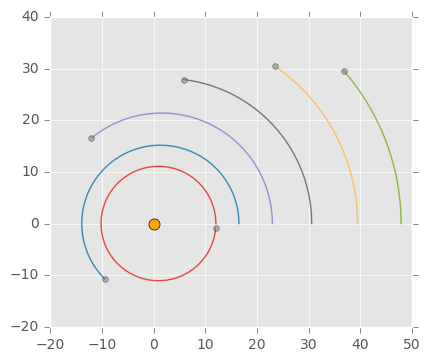

In [38]:
t, r, v = simulation.orbits(r0, v0, masses, t_max=1.5, dt=0.01)
analysis.plot_orbits(r)

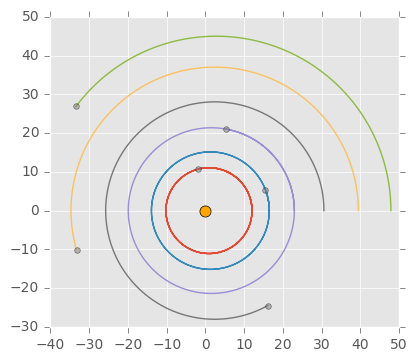

In [39]:
t, r, v = simulation.orbits(r0, v0, masses, t_max=5, dt=0.01)
analysis.plot_orbits(r)

Run the simulation for 1000 d.

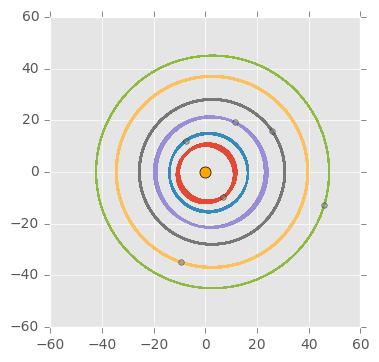

In [40]:
t, r, v = simulation.orbits(r0, v0, masses, t_max=1000, dt=0.01)
analysis.plot_orbits(r)

### Energy conservation
Test energy conservation

$$
E = T + U = \text{const}
$$

for the 1000-d run.

The `kinetic_energy()` and `U_gravity()` functions compute the energy for each planet and time step. To get the system energies, we have to sum over all bodies (`axis=-1`).

```python
KE = np.sum(analysis.kinetic_energy(v, masses), axis=-1)
U = np.sum(simulation.U_gravity(r, masses, M=star['mass']), axis=-1)
E_tot = KE + U
```

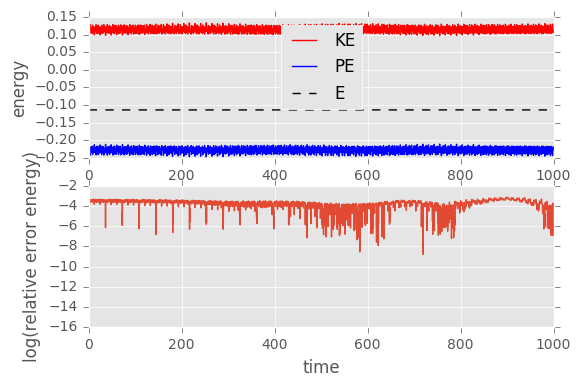

In [41]:
analysis.analyze_energies(t, r, v, simulation.U_gravity, m=masses)

Energy conservation is acceptable, given the time step of `dt = 0.01`. (The unit of time is 1 so for the step of $10^{-2}$ we expect an error on the order of `\Delta t^2`, i.e., $10^{-4}$ as seen.)

## BONUS: Star wobble 

For right now, see the messy [p2_solution.ipynb](p2_solution.ipynb) notebook.

## Analyze close planets

We want to count only planets as *nearby* by if we can resolve features of size `feature_size` with the nake eye:

In [51]:
feature_size = 1000 # km

Given the angular resolution of the naked eye ($\theta_\text{eye} = 1'$), we look for planets within a cutoff distance $d$ where features of size $y$ are still resolved:

$$
d(y) ≤ \frac{y}{\theta_\text{eye}}
$$


In [58]:
counts = analysis.find_nearby_planets(r, ymin=feature_size)

Plot the time series for TRAPPIST-1e

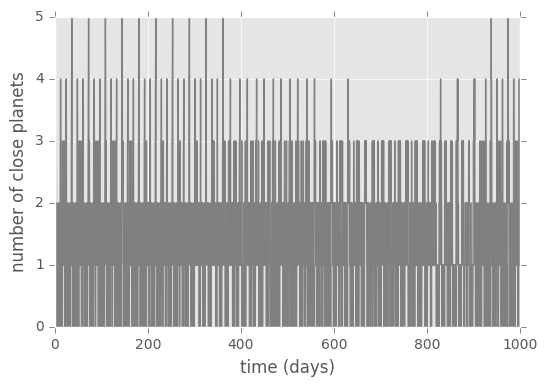

In [64]:
plt.plot(t, counts[:, 3], color="gray")
plt.xlabel("time (days)")
plt.ylabel(r"number of close planets")

Probability distribution for observing close planets:

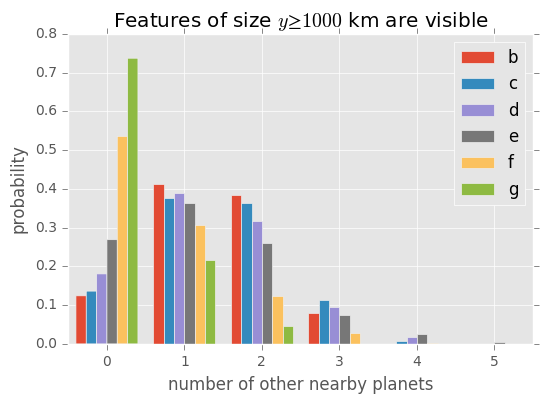

In [63]:
plt.hist(counts, bins=6, range=(-0.5, 5.5), normed=True, label=planets['name'])
plt.legend(loc="best")
plt.xlabel("number of other nearby planets")
plt.ylabel("probability")
plt.title("Features of size $y ≥ {}$ km are visible".format(feature_size))
plt.xlim(-0.5, 5.5);

## BONUS: Orbits with star moving 

(see [p2_solution.ipynb](p2_solution.ipynb) for right now.)